# 04.1 Working Geospatial Data: Raster Data 1: Hypsometric Curve

Raster data are perhaps the most conceptually straightforward form of geospatial data. A raster is simply a 2-dimensional gridded dataset situated somewhere on the surface of the Earth (or someother planetoid). To situate the grid, we need to know some important data such as: (1) the spatial coordinates of at least one pixel in an appropriate coordinate reference system (CRS) - usually the lower left one, (2) the number of rows and columns in the raster, (3) size of each pixel – most often each pixel will be equal size in x- and y-coordinates, but this doesn't have to be true, and (3) some number that tells us what data within the grid should be considered as not valid (i.e., a no-data value like -9999). There are a lot of nuances to this that are more appropriately dealt with in a GIS class. Things like rectilinear vs. curvilinear grids, appropriate CRSs and their transformations, and data storage conventions that might apply a scale factor and offset to store the data more efficiently. 

In this class, we're most interested in tools that allow us to analyze pre-prepared gridded datasets that encompass data like elevation and/or landcover. In this notebook, we will use a popular library called [rasterio](https://rasterio.readthedocs.io/en/stable/) to read in and analyze a digital elevation model (DEM) and land use/land cover for the Upper Boise River Basin (UBRB). If you're interested, I prepared and downloaded these data using Google Earth Engine, which has a great Python API. 

We'll start by loading the appropriate libraries. In this notebook, most of the libraries are standard ones we've used beflore. But `mpl_toolkits` provides us some advanced tools for manipulating Matplotlib plots, and `pygeohydro` is a somewhat bespoke library that gives us the standard National Land Cover Dataset (NLCD) colormap for land use.

In the notebook below, we will simply look at the land use/land cover and then compute and plot the so-called hypsometric curve of the UBRB – the proportion of a map at a particular elevation for all elevations. We will then use these plots to pose some additional questions we might want to ask. 

__Note:__ The GeoTiff data for this notebook can be found in [this Google Drive folder](https://drive.google.com/drive/folders/10zgh9vo9t2vGCMVmxl_zOzz9aT58_dMD?usp=sharing). Download it and copy it to a folder that you can reference below in the code. 

In [1]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygeohydro as gh

elev_fname = '../data/ubrb_dem_30m.tif'
lulc_fname = '../data/upper_boise_landcover_30m.tif'
# elev_fname = '../data/hfork_dem_30m.tif'
# lulc_fname = '../data/hfork_lulc_30m.tif'

plot_label = 'Upper Boise River'
# plot_label = 'Upper Snake River'

## Inspect the elevation raster

Open the DEM with rasterio, convert the first band to a NumPy array, and confirm the dataset metadata so we know what kind of objects we're working with and which CRS the grid uses.

In [2]:
# Open the DEM raster and pull the first (elevation) band into a NumPy array
elev_data = rio.open(elev_fname)
elev_array = elev_data.read(1)

# Inspect array dimensions (rows, columns)
elev_array.shape


(3239, 5433)

In [3]:
# Confirm the objects returned by rasterio and NumPy
print(type(elev_data))
print(type(elev_array))


<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>


In [4]:
# Record the coordinate reference system for spatial context
print(elev_data.crs)


EPSG:4269


## Load the land-cover layer

We repeat the process for the NLCD-based land-cover raster and verify that it lives in the same spatial reference as the elevation grid before moving on to any comparisons.

In [5]:
# Open the land-cover raster and load the classification band
lulc_data = rio.open(lulc_fname)
lulc_array = lulc_data.read(1)

# Check the array shape for consistency with the DEM
lulc_array.shape


(3239, 5433)

In [6]:
# Confirm the land-cover raster uses the same CRS as the DEM
print(lulc_data.crs)


EPSG:4269


## Plot the elevation grid

A quick map of the DEM helps confirm that the raster loaded correctly and gives a first look at basin relief.

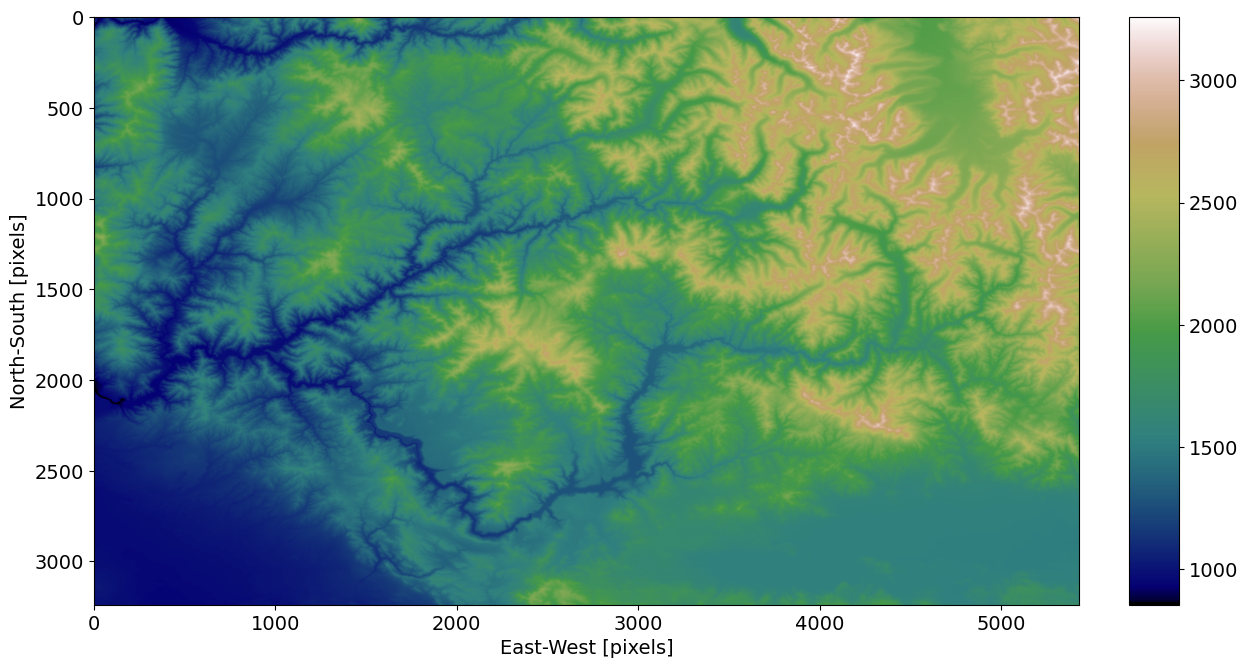

In [7]:
plt.rcParams.update({'font.size': 14})  # Improve readability of map labels

fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(elev_array,cmap='gist_earth')
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
divider = make_axes_locatable(ax)  # Place the colorbar outside the main axes
cax = divider.new_horizontal(size = '5%', pad = 0.5, pack_start = False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()


## Summarize elevation statistics

Basic descriptive statistics provide context for the hypsometric analysis and for interpreting the histogram bins we create next.

In [8]:
# Compute basic descriptive stats to summarize the elevation distribution
zmin = elev_array.min()
zmax = elev_array.max()
zmean = elev_array.mean()
zstd = elev_array.std()

zstats = f'''
Elevation Statistics:
Minimum elevation: {zmin:.{2}f} m
Maximum elevation: {zmax:.{2}f} m
Mean elevation: {zmean:.{2}f} m
Std. dev. elevation: {zstd:.{2}f} m
'''

print(zstats)



Elevation Statistics:
Minimum elevation: 853.23 m
Maximum elevation: 3259.66 m
Mean elevation: 1797.45 m
Std. dev. elevation: 476.46 m



## Map the land-cover categories

Using the NLCD color legend from `pygeohydro`, we can visualize dominant land-cover types across the basin and start relating them to elevation bands.

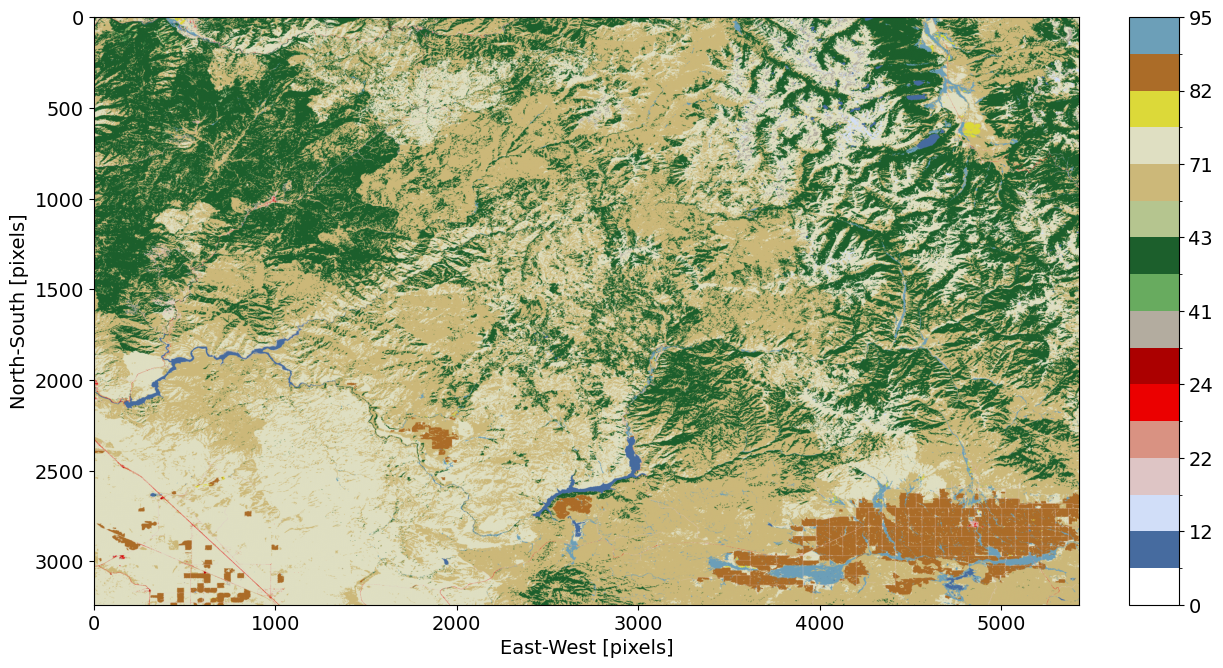

In [9]:
# Get NLCD colormap using pygeohydro tool stack 
cmap, norm, levels = gh.plot.cover_legends()

fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(np.flipud(lulc_array),cmap=cmap, norm=norm)  # Flip array so north is up in the display
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size = '5%', pad = 0.5, pack_start = False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()


## Build the hypsometric curve inputs

The hypsometric curve comes from a normalized elevation histogram. Here we bin the DEM, compute the fractional area in each bin, and store the cumulative sums for plotting.

In [10]:
# Bin the elevation data and compute fractional area for each bin
zhist, zbins = np.histogram(elev_array, bins=25)
zbin_center = (zbins[:-1] + zbins[1:])/2
zfrac = zhist/zhist.sum()


## Plot elevation distributions and hypsometric curves

We compare the raw histogram, the cumulative distribution, and two views of the hypsometric curve to understand how basin area accumulates with elevation.

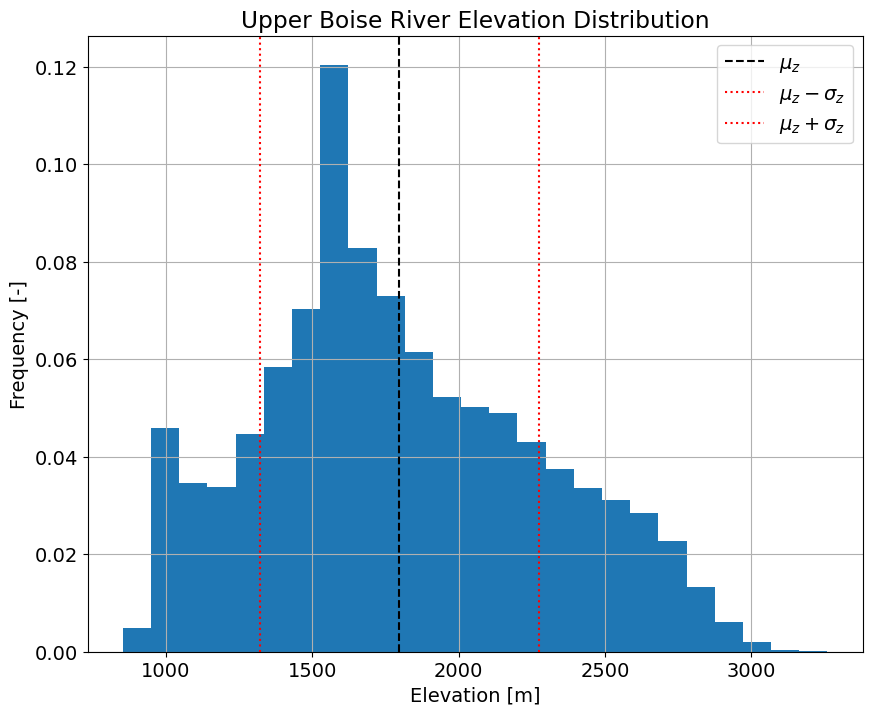

In [11]:
# Plot the normalized elevation histogram with mean and ±1σ markers
plt.figure(figsize=(10,8))
plt.bar(zbin_center,zfrac,width=1.0*(zbin_center[1]-zbin_center[0]))
plt.axvline(zmean, color='k', linestyle='--', label=r'\mu_z')
plt.axvline(zmean-zstd, color='r', linestyle=':', label=r'\mu_z - \sigma_z')
plt.axvline(zmean+zstd, color='r', linestyle=':', label=r'\mu_z + \sigma_z')
plt.title(plot_label+' Elevation Distribution')
plt.xlabel('Elevation [m]')
plt.ylabel('Frequency [-]')
plt.grid('on')
plt.legend()
plt.show()


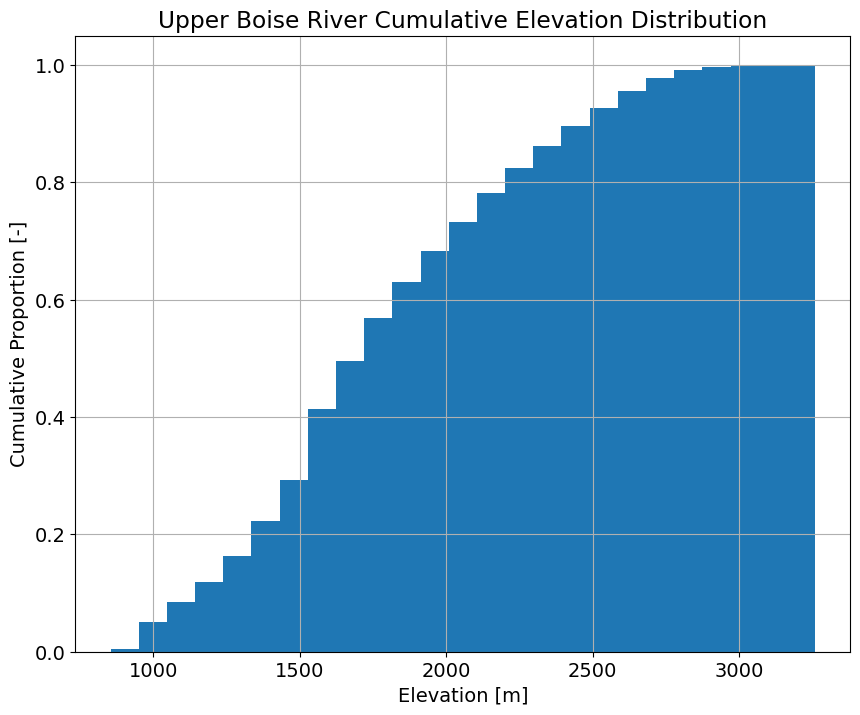

In [12]:
# Plot the cumulative elevation distribution (CDF)
plt.figure(figsize=(10,8))
plt.bar(zbin_center,zfrac.cumsum(),width=1.0*(zbin_center[1]-zbin_center[0]))
plt.title(plot_label+' Cumulative Elevation Distribution')
plt.xlabel('Elevation [m]')
plt.ylabel('Cumulative Proportion [-]')
plt.grid('on')
plt.show()


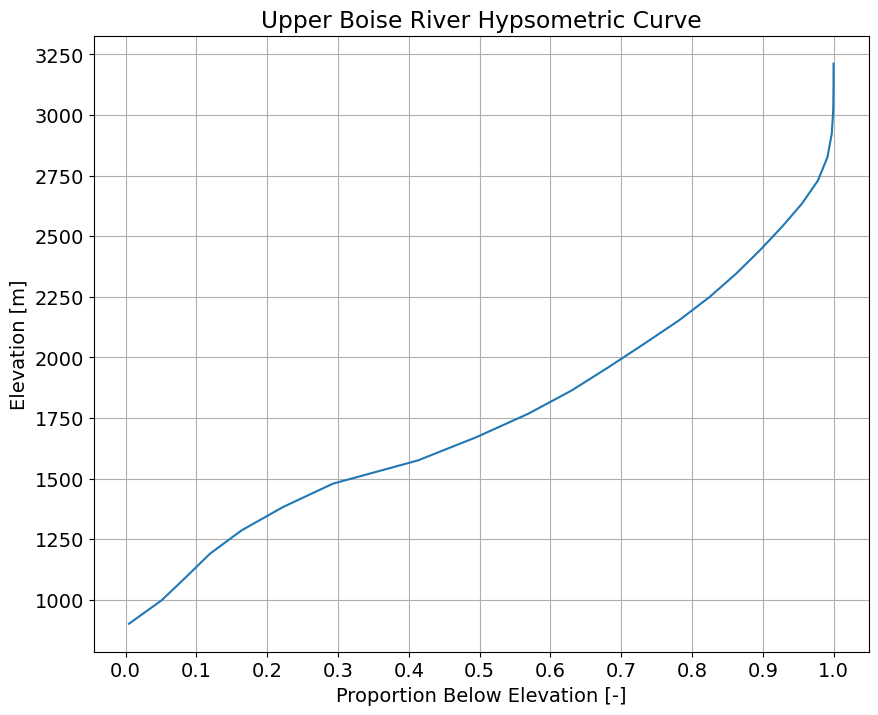

In [13]:
# Classic hypsometric curve showing the fraction of basin area below each elevation
plt.figure(figsize=(10,8))
plt.plot(zfrac.cumsum(),zbin_center)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(1000,3500,250))
plt.title(plot_label+' Hypsometric Curve')
plt.xlabel('Proportion Below Elevation [-]')
plt.ylabel('Elevation [m]')
plt.grid('on')
plt.show()


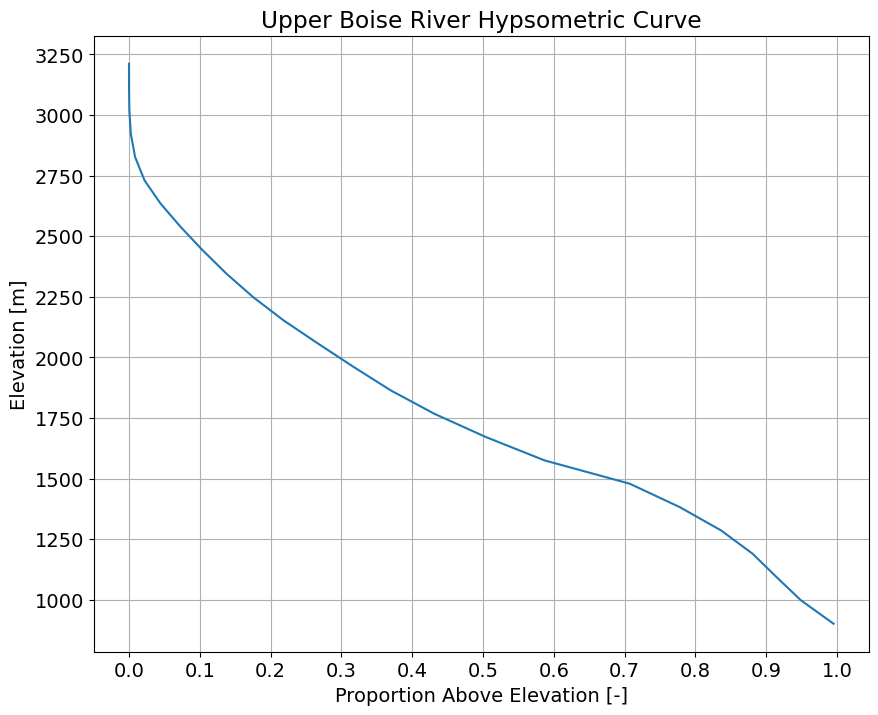

In [14]:
# Alternate hypsometric view showing the fraction of basin area above each elevation
plt.figure(figsize=(10,8))
plt.plot(1.0 - zfrac.cumsum(),zbin_center)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(1000,3500,250))
plt.title(plot_label+' Hypsometric Curve')
plt.xlabel('Proportion Above Elevation [-]')
plt.ylabel('Elevation [m]')
plt.grid('on')
plt.show()


## Wrap-up

These plots verify that the DEM and land-cover rasters align spatially and highlight elevation patterns in the Upper Boise River basin. Try swapping in another watershed to compare hypsometric shapes and land-cover mixes.